In [14]:
%config IPCompleter.greedy=True

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from nltk.collocations import *
import nltk
from nltk import FreqDist
import re


import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

import plotly.graph_objs as go




from wordcloud import WordCloud

In [15]:
#loading dataset
bd_complaints = "Consumer_Complaints.csv"
df = pd.read_csv(bd_complaints)

C:\Users\Bruno\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning:

Columns (5,6,11,16) have mixed types. Specify dtype option on import or set low_memory=False.



In [16]:
#Sample dataset
df2 = df.sample(10000)

#df2 = df.copy()

In [17]:
df2.head(2)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
124249,04/17/2019,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Investigation took more than 30 days,"I have sent a total of 3 letters, TO ALL 3 cre...",Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",FL,333XX,NaN,Consent provided,Web,04/17/2019,Closed with explanation,Yes,NaN,3214536
51426,07/21/2019,Mortgage,Conventional home mortgage,Closing on a mortgage,NaN,BASIC FACTS : In XX/XX/2019 I agreed to buy an...,Company has responded to the consumer and the ...,WELLS FARGO & COMPANY,MA,021XX,NaN,Consent provided,Web,07/21/2019,Closed with explanation,Yes,NaN,3313623


In [18]:
#Transforming date into date object
df2['new_date'] = pd.to_datetime(df2['Date received'], 
                                 format='%m/%d/%Y', 
                                 errors='coerce')
df2['new_date'] = pd.to_datetime(df2['new_date'])


#Extracting year, month, day_name
df2['year'] = pd.DatetimeIndex(df2['new_date']).year
df2['month'] = pd.DatetimeIndex(df2['new_date']).month
df2['month_name'] = pd.DatetimeIndex(df2['new_date']).month_name()
df2['day'] = pd.DatetimeIndex(df2['new_date']).day_name()
df2['day_number'] = pd.DatetimeIndex(df2['new_date']).day

#Counting the number of words of every complaint
df2['len_complaint'] = df2['Consumer complaint narrative'].str.split().str.len()

#Sorting

df2 = df2.sort_values(by=['new_date'],ascending=False)

In [19]:
#Before doing text analysis I will work in  plots with the number of complaints and other stuff

#layout1 = cf.Layout(
#    height=800,
#    width=600
#)

#Number of complaints by day of the week (may be there is some )
df2.groupby('day').count()['Date received'].sort_values(ascending=False).iplot(kind='bar', yTitle='Count', linecolor='black', opacity=0.6, title='Number of complaints by day of the week', xTitle='Day of the Week', colors='blue' )


In [20]:

#Number of complaints by month, (excluding last year)
df2[df2['year']<2019].groupby('month_name').count()['Date received'].sort_values(ascending=False).iplot(kind='bar', yTitle='Count', linecolor='black', opacity=0.6, title='Number of complaints by month', xTitle='Month', colors='red' )


In [21]:
#Number of complaints by type of product

df2.groupby('Product').count()['Date received'].sort_values(ascending=False).iplot(kind='bar', yTitle='Count', linecolor='black', opacity=0.6, title='Number of complaints by Product', xTitle='Product', colors='darkcyan')


In [102]:

#Evolution over the of complaints of the top 4 products


#pivot table, long to wide format

df2_t = pd.pivot_table(df2, values='len_complaint', index=['new_date'],
                   columns=['Product'], aggfunc='count')



df2_t = df2_t[['Credit reporting, credit repair services, or other personal consumer reports','Mortgage','Debt collection','Credit reporting']]


my_fig = df2_t.iplot(subplots=True, 
                     shape=(4,1), 
                     shared_xaxes=True, 
                     fill=True, 
                     asFigure=True,
                     title='Evolution over the time of complaints of the top 4 products')

my_fig.layout.legend=dict(x=-.1, y=-.5)
my_fig.iplot()



In [23]:
#Complaint length histogram


hist_len = df2['len_complaint'].iplot(
            kind='hist',
            bins=400,
            xTitle='complaint length',
            linecolor='black',
            yTitle='count',
            title='Complaint length histogram',
            asFigure=True,
            color='blue')

hist_len.layout.legend=dict(x=-.1, y=-.5)
hist_len.update_xaxes(range=[0, 1000])
hist_len.iplot()



In [158]:
#Boxplot, usefull to identify outliers, and compare medians between products


df_bx = df2[['Product','len_complaint','new_date']]
df_bx= df_bx.dropna()



###Its neccesary to divide the dataset to plot correctly the boxplots:

df_bx_1 = df_bx.loc[df_bx['Product'] == "Mortgage"]
df_bx_1['Mortgage'] = df_bx_1['len_complaint']
df_bx_1.drop(['len_complaint', 'Product' ,'new_date'], inplace=True, axis=1)


df_bx_2 = df_bx.loc[df_bx['Product'] == "Credit reporting, credit repair services, or other personal consumer reports"]
df_bx_2['Credit_report_services'] = df_bx_2['len_complaint']
df_bx_2.drop(['len_complaint', 'Product' ,'new_date'], inplace=True, axis=1)


df_bx_3 = df_bx.loc[df_bx['Product'] == "Debt collection"]
df_bx_3['Debt collection'] = df_bx_3['len_complaint']
df_bx_3.drop(['len_complaint', 'Product' ,'new_date'], inplace=True, axis=1)


df_bx_4 = df_bx.loc[df_bx['Product'] == "Credit reporting"]
df_bx_4['Credit reporting'] = df_bx_4['len_complaint']
df_bx_4.drop(['len_complaint', 'Product' ,'new_date'], inplace=True, axis=1)



df_bx_plot = pd.concat([df_bx_1, df_bx_2, df_bx_3, df_bx_4], ignore_index=True, axis=1)


df_bx_plot.rename(columns={0: 'Mortgage', 1: 'Credit_report_services', 2: 'Debt_collection', 3:'Credit_reporting'}, inplace=True)



box_fig = df_bx_plot.iplot(kind='box',
                          asFigure=True,
                          title='Length of the complaints')


box_fig.add_trace(go.Box(
                     name='Only Mean',
                     marker_color='darkblue',
                     boxmean=True))
box_fig.layout.legend=dict(x=-.1, y=-.5)
box_fig.iplot()


# Text analysis

In [25]:
#There a lot of missing valius into the complaints, in this case it's not possible to impute because is "free text" data
#For that reason they're going to be deleted

#creating a new data set without missing values in the consumer complaint narrative
df3 = df2.copy()
df3 = df3[df3['Consumer complaint narrative'].notnull()]
          
#Counting the number of words of every complaint





In [361]:
###Using regular expressions I will try to identify in every complaint an amount of money
###May be useful to generate an indicator of importance of the complaint



#this expression identify money of the form:
#$xxx.yy xxx.y
#xxx.yy xxx.y
#xxxk

pattern = "(\$[0-9]+\.?[0-9]{1,2}|[0-9]+k)"
df3['money1'] = df3['Consumer complaint narrative'].apply(lambda x: re.findall(pattern, str(x)))

In [388]:
###Transforming the symbol $ into "" , and k into "000"

df3['money2'] = df3['money1'].apply(lambda x: ' '.join(x).replace('$',''))
df3['money3'] = df3['money2'].apply(lambda x: x.replace('k','000'))
df3['money3'] = df3['money2'].apply(lambda x: x.replace('k','000'))
df3['money4'] = df3['money2'].apply(lambda x: x.split())


df3.head()

,index,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,...,year,month,month_name,day,day_number,len_complaint,money1,money2,money3,money4
0,1581,09/20/2019,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account status incorrect,I took out a loan in XX/XX/XXXX and paid it of...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",TX,...,2019,9,September,Friday,20,165.0,[],,,[]
1,4227,09/16/2019,Mortgage,Conventional home mortgage,Closing on a mortgage,NaN,Working with Loan Depot on a refinance since a...,Company believes complaint is the result of an...,"LD Holdings Group, LLC",TX,...,2019,9,September,Monday,16,262.0,[],,,[]
2,4499,09/16/2019,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Old information reappears or never goes away,Old information that was removed is now reappe...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",NY,...,2019,9,September,Monday,16,8.0,[],,,[]
3,4598,09/15/2019,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Public record information inaccurate,Student loans was put in with my Chapter XXXX ...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,KS,...,2019,9,September,Sunday,15,141.0,"[$1900.00, $3500.00, $1900.00, $3600.00, $1900...",1900.00 3500.00 1900.00 3600.00 1900.00 3500.0...,1900.00 3500.00 1900.00 3600.00 1900.00 3500.0...,"[1900.00, 3500.00, 1900.00, 3600.00, 1900.00, ..."
4,5146,09/14/2019,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,This is a follow up complaint to a complaint I...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,OH,...,2019,9,September,Saturday,14,72.0,[],,,[]


In [160]:
#Transforming all the complaints into one single string, usefull to do some basic frequency analysis.
all_complains = ' '.join(df3['Consumer complaint narrative'].tolist())
#printing first 2000 words:
all_complains[0:4000]
                         


'I took out a loan in XX/XX/XXXX and paid it of in XX/XX/XXXX. It was reported as so for the following months.\n\nRecently, I took out another loan with the company in XX/XX/XXXX. Suddenly, the old account began reporting as 60 days late. I contacted them and they fixed it, however, it is now reporting 30 days late from XX/XX/XXXX and XX/XX/XXXX. This is after for the past 9 months it has reported on-time. Why would my credit report on an account that was closed 3 months ago suddenly change???\n\nI am in the middle of a refinance and this is very detrimental. I respectfully request that this account be updated to all payments on time, as has been reported every month until now - months after the account was closed. This is erroneous information and in contradiction to what has been previously reported.\n\nFurthermore, this is at tribal loan company that should actually not be reporting to credit bureaus in my state at all. Working with Loan Depot on a refinance since application on XX/

In [159]:
#Transforming the text into lowercase 

all_complains_2 = all_complains.lower()

#removing special characters (just keeping text, numbers and dollar symbol)
pattern = '[^a-zA-Z0-9-$]+'
all_complains_2 = re.sub(pattern,' ',all_complains_2)

#printing first 2000 words:
all_complains_2[0:4000]


'i took out a loan in xx xx xxxx and paid it of in xx xx xxxx it was reported as so for the following months recently i took out another loan with the company in xx xx xxxx suddenly the old account began reporting as 60 days late i contacted them and they fixed it however it is now reporting 30 days late from xx xx xxxx and xx xx xxxx this is after for the past 9 months it has reported on-time why would my credit report on an account that was closed 3 months ago suddenly change i am in the middle of a refinance and this is very detrimental i respectfully request that this account be updated to all payments on time as has been reported every month until now - months after the account was closed this is erroneous information and in contradiction to what has been previously reported furthermore this is at tribal loan company that should actually not be reporting to credit bureaus in my state at all working with loan depot on a refinance since application on xx xx 2019 was told i could sho

In [28]:
#Transforming the words into tokens
complains_token = nltk.word_tokenize(all_complains_2)

#View the top 100 most frequenty words:
fdist1 = FreqDist(complains_token)
fdist1.most_common(50)

[('xxxx', 33915),
 ('the', 26638),
 ('i', 23636),
 ('to', 21412),
 ('and', 17024),
 ('my', 12951),
 ('a', 12705),
 ('of', 10756),
 ('that', 10072),
 ('xx', 8972),
 ('was', 8276),
 ('on', 7505),
 ('in', 7388),
 ('they', 7311),
 ('this', 6770),
 ('have', 6617),
 ('not', 6196),
 ('for', 6150),
 ('is', 5819),
 ('me', 5587),
 ('with', 5229),
 ('credit', 5184),
 ('it', 4528),
 ('account', 4281),
 ('from', 3905),
 ('as', 3495),
 ('$', 3176),
 ('00', 2978),
 ('be', 2899),
 ('had', 2771),
 ('or', 2503),
 ('them', 2481),
 ('information', 2379),
 ('by', 2307),
 ('an', 2277),
 ('are', 2254),
 ('report', 2213),
 ('would', 2139),
 ('been', 2077),
 ('no', 1992),
 ('has', 1989),
 ('loan', 1960),
 ('at', 1957),
 ('payment', 1948),
 ('all', 1931),
 ('but', 1883),
 ('do', 1697),
 ('any', 1694),
 ('which', 1683),
 ('did', 1677)]

In [29]:
#removing stop words:


#removing stop words

from nltk.corpus import stopwords 
stop_words = set(stopwords.words('english')) 


complains_token_sw = [w for w in complains_token if not w in stop_words]



fdist2 = FreqDist(complains_token_sw)
fdist2.most_common(50)

[('xxxx', 33915),
 ('xx', 8972),
 ('credit', 5184),
 ('account', 4281),
 ('$', 3176),
 ('00', 2978),
 ('information', 2379),
 ('report', 2213),
 ('would', 2139),
 ('loan', 1960),
 ('payment', 1948),
 ('told', 1611),
 ('debt', 1587),
 ('bank', 1583),
 ('received', 1556),
 ('company', 1451),
 ('card', 1413),
 ('reporting', 1329),
 ('time', 1299),
 ('never', 1296),
 ('called', 1263),
 ('sent', 1236),
 ('letter', 1209),
 ('payments', 1201),
 ('back', 1103),
 ('also', 1093),
 ('pay', 1058),
 ('get', 1052),
 ('paid', 1047),
 ('said', 1018),
 ('call', 997),
 ('number', 982),
 ('n', 978),
 ('could', 975),
 ('mortgage', 972),
 ('amount', 971),
 ('accounts', 940),
 ('consumer', 935),
 ('one', 933),
 ('money', 930),
 ('made', 918),
 ('phone', 913),
 ('due', 903),
 ('balance', 878),
 ('asked', 869),
 ('days', 867),
 ('still', 854),
 ('even', 815),
 ('collection', 789),
 ('dispute', 774)]

In [30]:
#adding to the original stopwords list

new_stop = ['xxxx' , 'xx' , '$' ,'00' , 'n' ]
stop_words_2 = stop_words.union(new_stop)

complains_token_sw = [w for w in complains_token if not w in stop_words_2]

#Creating text object from new tokenization
complains_textnl = nltk.Text(complains_token_sw)

fdist3 = FreqDist(complains_token_sw)
fdist3.most_common(50)

[('credit', 5184),
 ('account', 4281),
 ('information', 2379),
 ('report', 2213),
 ('would', 2139),
 ('loan', 1960),
 ('payment', 1948),
 ('told', 1611),
 ('debt', 1587),
 ('bank', 1583),
 ('received', 1556),
 ('company', 1451),
 ('card', 1413),
 ('reporting', 1329),
 ('time', 1299),
 ('never', 1296),
 ('called', 1263),
 ('sent', 1236),
 ('letter', 1209),
 ('payments', 1201),
 ('back', 1103),
 ('also', 1093),
 ('pay', 1058),
 ('get', 1052),
 ('paid', 1047),
 ('said', 1018),
 ('call', 997),
 ('number', 982),
 ('could', 975),
 ('mortgage', 972),
 ('amount', 971),
 ('accounts', 940),
 ('consumer', 935),
 ('one', 933),
 ('money', 930),
 ('made', 918),
 ('phone', 913),
 ('due', 903),
 ('balance', 878),
 ('asked', 869),
 ('days', 867),
 ('still', 854),
 ('even', 815),
 ('collection', 789),
 ('dispute', 774),
 ('date', 742),
 ('since', 738),
 ('late', 731),
 ('name', 708),
 ('please', 689)]

<Figure size 432x288 with 0 Axes>

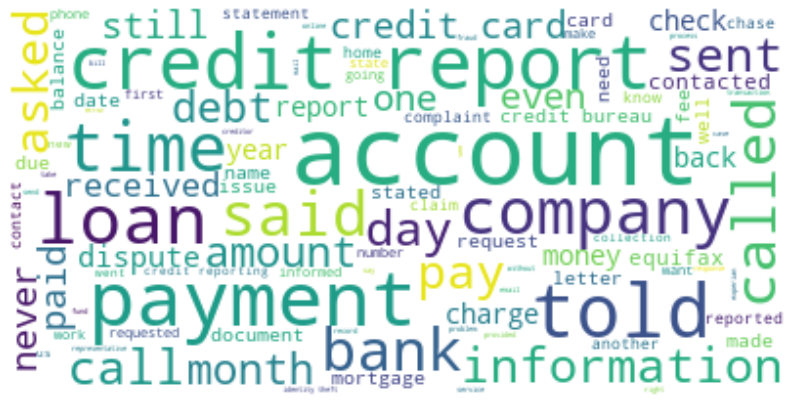

In [31]:
#creating a word cloud

#generating the text without stopwords into one string
text_wc = ' '.join(complains_token_sw)

#Generatig the wordcloud object
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text_wc)
#plotting the wordcloud



plt.figure()
plt.figure(figsize = (14, 14), facecolor = None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

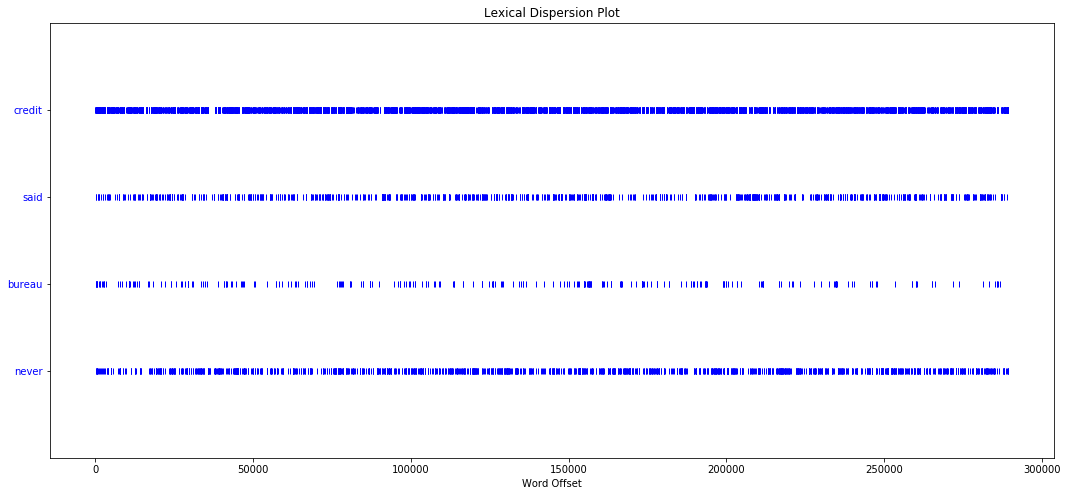

In [32]:
#

plt.figure(figsize = (18, 8), facecolor = None)
complains_textnl.dispersion_plot(['credit','said','bureau','never'])




In [33]:
df2_t

Product,"Credit reporting, credit repair services, or other personal consumer reports",Mortgage,Debt collection,Credit reporting
new_date,,,,
2011-12-01,NaN,1.0,NaN,NaN
2011-12-02,NaN,NaN,NaN,NaN
2011-12-05,NaN,NaN,NaN,NaN
2011-12-06,NaN,NaN,NaN,NaN
2011-12-08,NaN,1.0,NaN,NaN
2011-12-09,NaN,1.0,NaN,NaN
2011-12-10,NaN,NaN,NaN,NaN
2011-12-12,NaN,1.0,NaN,NaN
2011-12-14,NaN,3.0,NaN,NaN


In [34]:
df2.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,...,Timely response?,Consumer disputed?,Complaint ID,new_date,year,month,month_name,day,day_number,len_complaint
196,09/27/2019,Vehicle loan or lease,Loan,Managing the loan or lease,Billing problem,NaN,NaN,AMERICAN HONDA FINANCE CORP,NY,11731,...,Yes,NaN,3388647,2019-09-27,2019,9,September,Friday,27,NaN
349,09/26/2019,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,"EQUIFAX, INC.",FL,331XX,...,Yes,NaN,3387236,2019-09-26,2019,9,September,Thursday,26,NaN
284,09/26/2019,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,"EARLY WARNING SERVICES, LLC",NY,113XX,...,Yes,NaN,3386796,2019-09-26,2019,9,September,Thursday,26,NaN
302,09/26/2019,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Old information reappears or never goes away,NaN,NaN,"Commonwealth Financial Systems, Inc.",NY,NaN,...,Yes,NaN,3387501,2019-09-26,2019,9,September,Thursday,26,NaN
392,09/25/2019,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Personal information incorrect,NaN,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",MI,48504,...,Yes,NaN,3385598,2019-09-25,2019,9,September,Wednesday,25,NaN


In [35]:
df_bx = df2[['Product','len_complaint']]
df_bx= df_bx.dropna()

In [36]:
df_bx.head()

df_bx_1 = df_bx.loc[df_bx['Product'] == "Debt collection"]
#df_bx_1 = df_bx_1['len_complaint']
#df_bx_1.rename(columns={"len_complaint": "Debt_collection"})

df_bx_1 = df_bx_1.drop('Product',1)

df_bx_2 = df_bx.loc[df_bx['Product'] == "Mortgage"]
df_bx_2 = df_bx_2['len_complaint']
df_bx_2 = df_bx_2.drop('Product',1)





df_bx_1.head()

,len_complaint
5947,106.0
7234,25.0
8664,166.0
14264,292.0
23912,398.0


In [64]:

box_fig = df_bx_1.iplot(kind='box',
                          asFigure=True,)


box_fig.add_trace(go.Box(
                     name='Only Mean',
                     marker_color='darkblue',
                     boxmean=True))
box_fig.layout.legend=dict(x=-.1, y=-.5)


box_fig2 = df_bx_1.iplot(kind='box',
                          asFigure=True,)


box_fig2.add_trace(go.Box(
                     name='Only Mean',
                     marker_color='darkblue',
                     boxmean=True))
box_fig2.layout.legend=dict(x=-.1, y=-.5)



#box_fig.iplot()

In [67]:
#cf.subplots([df1.figure(kind='bar',categories='category'),
#         df2.figure(kind='bar',categories='category')],shape=(2,1)).iplot()





type(cf.subplots([box_fig,box_fig2]))

dict

In [38]:
df_bx_1.columns

Index(['len_complaint'], dtype='object')

In [39]:
df_bx['Product_aux'] = "product"

In [98]:
df_bx

,Product,len_complaint,Product_aux
1581,"Credit reporting, credit repair services, or o...",165.0,product
4227,Mortgage,262.0,product
4499,"Credit reporting, credit repair services, or o...",8.0,product
4598,"Credit reporting, credit repair services, or o...",141.0,product
5146,"Credit reporting, credit repair services, or o...",72.0,product
5658,Mortgage,96.0,product
6410,"Credit reporting, credit repair services, or o...",602.0,product
5947,Debt collection,106.0,product
5746,"Credit reporting, credit repair services, or o...",68.0,product
7234,Debt collection,25.0,product


In [101]:
df2_len_t

Product,"Credit reporting, credit repair services, or other personal consumer reports",Mortgage,Debt collection,Credit reporting
new_date,,,,
2015-03-20,NaN,NaN,NaN,2.0
2015-03-21,NaN,NaN,NaN,NaN
2015-03-27,NaN,NaN,NaN,NaN
2015-03-29,NaN,1.0,NaN,NaN
2015-03-30,NaN,NaN,NaN,NaN
2015-03-31,NaN,NaN,NaN,NaN
2015-04-01,NaN,NaN,NaN,NaN
2015-04-02,NaN,NaN,1.0,NaN
2015-04-03,NaN,NaN,NaN,1.0


In [104]:
df2_len_t

Product,"Credit reporting, credit repair services, or other personal consumer reports",Mortgage,Debt collection,Credit reporting
new_date,,,,
2015-03-20,NaN,NaN,NaN,2.0
2015-03-21,NaN,NaN,NaN,NaN
2015-03-27,NaN,NaN,NaN,NaN
2015-03-29,NaN,1.0,NaN,NaN
2015-03-30,NaN,NaN,NaN,NaN
2015-03-31,NaN,NaN,NaN,NaN
2015-04-01,NaN,NaN,NaN,NaN
2015-04-02,NaN,NaN,1.0,NaN
2015-04-03,NaN,NaN,NaN,1.0


In [146]:
###Its neccesary to divide the dataset to plot correctly the boxplots:

df_bx_1 = df_bx.loc[df_bx['Product'] == "Mortgage"]
df_bx_1['Mortgage'] = df_bx_1['len_complaint']
df_bx_1.drop(['len_complaint', 'Product' ,'new_date'], inplace=True, axis=1)


df_bx_2 = df_bx.loc[df_bx['Product'] == "Credit reporting, credit repair services, or other personal consumer reports"]
df_bx_2['Credit_report_services'] = df_bx_2['len_complaint']
df_bx_2.drop(['len_complaint', 'Product' ,'new_date'], inplace=True, axis=1)


df_bx_3 = df_bx.loc[df_bx['Product'] == "Debt collection"]
df_bx_3['Debt collection'] = df_bx_3['len_complaint']
df_bx_3.drop(['len_complaint', 'Product' ,'new_date'], inplace=True, axis=1)


df_bx_4 = df_bx.loc[df_bx['Product'] == "Credit reporting"]
df_bx_4['Credit reporting'] = df_bx_4['len_complaint']
df_bx_4.drop(['len_complaint', 'Product' ,'new_date'], inplace=True, axis=1)



df_bx_plot = pd.concat([df_bx_1, df_bx_2, df_bx_3, df_bx_4], ignore_index=True, axis=1)


df_bx_plot.rename(columns={0: 'Mortgage', 1: 'Credit_report_services', 2: 'Debt_collection', 3:'Credit_reporting'}, inplace=True)



'Credit reporting, credit repair services, or other personal consumer reports','Mortgage','Debt collection','Credit reporting'



df_bx.head()




,Product,len_complaint,new_date
1581,"Credit reporting, credit repair services, or o...",165.0,2019-09-20
4227,Mortgage,262.0,2019-09-16
4499,"Credit reporting, credit repair services, or o...",8.0,2019-09-16
4598,"Credit reporting, credit repair services, or o...",141.0,2019-09-15
5146,"Credit reporting, credit repair services, or o...",72.0,2019-09-14


In [147]:
df_bx_plot.iplot(kind='box')

In [312]:
import re
#patterb to find all the messages inside parentheses:
#pattern = "\$(([0-9]+\.?[0-9]{1,2})|([0-9]+k))"

pattern = "(\$[0-9]+\.?[0-9]{1,2}|[0-9]+k)"


texto = "{$1900.00} XX/XX/XXXX Direct UnSub Stattford Loan 300.00k  y 200k  {$3600.00} XX/XX/XXXX Direct Sub Stattford Loan {$1900.00} XX/XX/XXXX Direct Unsub Stattford Loan {$3500.00} XX/XX/XXXX Direct Sub Stattford Loan {$3.00}, XXXX This is a follow"

x = re.findall(pattern,texto)

In [313]:
texto

'{$1900.00} XX/XX/XXXX Direct UnSub Stattford Loan 300.00k  y 200k  {$3600.00} XX/XX/XXXX Direct Sub Stattford Loan {$1900.00} XX/XX/XXXX Direct Unsub Stattford Loan {$3500.00} XX/XX/XXXX Direct Sub Stattford Loan {$3.00}, XXXX This is a follow'

In [314]:
x

['$1900.00', '00k', '200k', '$3600.00', '$1900.00', '$3500.00', '$3.00']

In [315]:
x

['$1900.00', '00k', '200k', '$3600.00', '$1900.00', '$3500.00', '$3.00']

In [316]:
x

['$1900.00', '00k', '200k', '$3600.00', '$1900.00', '$3500.00', '$3.00']

In [317]:
x = [w.replace('$', '') for w in x]
x = [w.replace('k', '000') for w in x]

x

['1900.00', '00000', '200000', '3600.00', '1900.00', '3500.00', '3.00']

In [318]:
min(x)

'00000'

In [297]:
max(x)

'3600.00'

In [298]:
for j in x:
    print(type(j))

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>


# Saving notebook into a html file



In [4]:
from nbconvert import HTMLExporter
import codecs
import nbformat
exporter = HTMLExporter()

jupyter_file = "Pract2.ipynb"
output_html = "Pract2.html"

output_notebook = nbformat.read(jupyter_file, as_version=4)
output, resources = exporter.from_notebook_node(output_notebook)
codecs.open(output_html, 'w', encoding='utf-8').write(output)